# Build Your Own SFINCS Hydrodynamic Model

## Overview

This interactive notebook allows you to build a custom **SFINCS hydrodynamic model** for any location in East Africa. Using an interactive map, you can select your model region, configure model parameters, and generate a complete hydrodynamic model ready for simulation.


### What You'll Do

1. **Select your model region** using an interactive map
2. **Configure model parameters** including grid resolution and forcing data
3. **Build your model** automatically using HydroMT-SFINCS
4. **Visualize the results** to verify your model setup
---

## Prerequisites

Before starting, ensure you have:
- Completed the SFINCS training notebook (1_Run_DireDawa_SFINCS_model.ipynb)
- Selected the **"HydroMT SFINCS (pixi)"** kernel (top-right corner)
- Prepared your data catalogs and configuration files

---


In [18]:
# Standard library imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import folium


## Part 1: Interactive Map for Region Selection

### Create Interactive Map

Use this interactive map to:
- **Visualize** reference layers (coastal areas, rivers, elevation)
- **Click** to define your model region bounding box
- **View** the coordinates of your selected area

The map will display your click coordinates in latitude and longitude.

In [12]:
# define a point for a city
# nairobi
lat = -1.286389
lon = 36.817223

selected_coords = {'lat': None, 'lon': None, 'bbox': None}

import folium
from folium import plugins 

def create_interactive_map(
    center=[9.5, 41.0], 
    zoom=7, 
    geojson_files=None):
    """
    Create an interactive Folium map with click functionality for SFINCS model setup.
    
    Parameters:
    -----------
    center : list
        [latitude, longitude] for map center (default: Dire Dawa region)
    zoom : int
        Initial zoom level
    geojson_files : dict
        Dictionary of {layer_name: file_path} for GeoJSON layers
    
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Create base map
    m = folium.Map(
        location=center,
        zoom_start=zoom,
        tiles='OpenStreetMap',
        control_scale=True
    )
    
 # Add alternative base layers
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Add satellite imagery with labels overlay
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Labels',
        overlay=True,
        control=True,
        show=True
    ).add_to(m)
    
    
    # Add GeoJSON layers if provided
    if geojson_files:
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        for idx, (layer_name, file_path) in enumerate(geojson_files.items()):
            if Path(file_path).exists():
                try:
                    color = colors[idx % len(colors)]
                    folium.GeoJson(
                        str(file_path),
                        name=layer_name,
                        style_function=lambda x, c=color: {
                            'fillColor': c,
                            'color': c,
                            'weight': 2,
                            'fillOpacity': 0.3
                        }
                    ).add_to(m)
                except Exception as e:
                    print(f"Warning: Could not load {layer_name}: {e}")
    
    # Add click functionality for coordinate capture
    m.add_child(folium.LatLngPopup())
    
    # Add drawing tools for bounding box
    draw = plugins.Draw(
        export=False,
        draw_options={
            'polyline': False,
            'rectangle': True,
            'polygon': True,  # Enable polygon drawing
            'circle': False,
            'circlemarker': False,
            'marker': True
        }
    )
    draw.add_to(m)
    
    # Add measure control
    plugins.MeasureControl(position='topleft', primary_length_unit='kilometers').add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add custom HTML for instructions
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 280px; height: auto; 
                background-color: white; z-index:9999; font-size:14px;
                border:2px solid grey; border-radius: 5px; padding: 10px">
    <h4 style="margin-top: 0;">SFINCS Model Setup</h4>
    <p><b>1.</b> Use the rectangle tool (◼) to define your model domain</p>
    <p><b>2.</b> Click on the map to see coordinates</p>
    <p><b>3.</b> Copy the bounding box coordinates</p>
    <p><b>4.</b> Enter them in the widget below</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create the map
print("Creating interactive map...")
map_widget = create_interactive_map(
    center=[9.5, 41.0],  # Default center (Dire Dawa region)
    zoom=7,
)

# Display the map
display(map_widget)

Creating interactive map...


<Axes: >

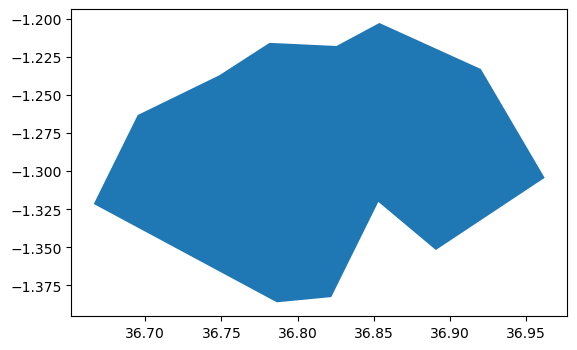

In [13]:
# create as geodataframe of
from shapely.geometry import shape
import geopandas as gpd

shp = {"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[36.695023,-1.263325],[36.666183,-1.321675],[36.786346,-1.386202],[36.822052,-1.38277],[36.852951,-1.320302],[36.890717,-1.35188],[36.962128,-1.304514],[36.920242,-1.23312],[36.853638,-1.202915],[36.825485,-1.218017],[36.78154,-1.215958],[36.748581,-1.237239],[36.695023,-1.263325]]]}}
polygon = shape(shp['geometry'])

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")
gdf.plot()


In [14]:
# save as region.geojson
gdf.to_file("region.geojson", driver='GeoJSON')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniforge3/envs/hydromt_sfincs/share/proj failed


In [15]:
# To check the version of hydromt and the hydromt_sfincs plugin, run the following command in a terminal:
!/opt/miniforge3/envs/hydromt_sfincs/bin/hydromt --models

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniforge3/envs/hydromt_sfincs/share/proj failed
model plugins:
 - wflow (hydromt_wflow 0.8.0)
 - wflow_sediment (hydromt_wflow 0.8.0)
 - sfincs (hydromt_sfincs 1.2.1)
generic models (hydromt 0.10.1):
 - grid_model
 - vector_model
 - mesh_model
 - network_model



In [62]:
! /opt/miniforge3/envs/hydromt_sfincs/bin/hydromt build sfincs my_own_sfincs_model --region "{'geom': 'region.geojson'}" -i ../model_build_files/sfincs_build_my_own_model.yml --force-overwrite -v -d ../model_build_files/hydromt_east_africa_sfincs.yml

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniforge3/envs/hydromt_sfincs/share/proj failed
2025-11-26 05:51:45,758 - build - log - INFO - HydroMT version: 0.10.1
2025-11-26 05:51:45,758 - build - main - INFO - Building instance of sfincs model at /home/thomasstolp/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/2_Hydrodynamic_Model/my_own_sfincs_model.
2025-11-26 05:51:45,758 - build - main - INFO - User settings:
2025-11-26 05:51:45,787 - build - data_catalog - INFO - Parsing data catalog from ../model_build_files/hydromt_east_africa_sfincs.yml
2025-11-26 05:51:45,798 - build - model_api - WARNING - Model dir already exists and files might be overwritten: /home/thomasstolp/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/2_Hydrodynamic_Model/my_own_sfincs_model/gis.
2025-11-26 05:51:45,798 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.2.1).
2025-11-26 05:51:45,799 - build - model_api - INFO - setup_grid_from_

In [63]:
model = SfincsModel(model_dir, mode="r")

In [65]:
=

ImportError: cannot import name 'SfincsGrid' from 'hydromt_sfincs' (/opt/miniforge3/envs/hydromt_sfincs/lib/python3.11/site-packages/hydromt_sfincs/__init__.py)

In [70]:

model.grid.create_from_region(
    region= {'path': 'region.geojson'}, 
    res= 50, 
    crs= 'utm', 
   )

ValueError: Grid type is not set. Please read configuration file (sfincs.inp) first.

In [ ]:
# copy template precipitation file
src = Path("/data/shared/sfincs/precip_2d.nc")
dst = Path("precip_2d.nc")
shutil.copy2(src, target)
print("Copied file!")

In [24]:
def create_sfincs_precipitation_netcdf(
    precip_config,
    template_path
):
    """
    Create a precipitation NetCDF file for SFINCS with constant or varying values.
    
    Parameters:
    -----------
    model_dir : Path
        Path to model directory
    precip_config : dict
        Dictionary with keys: precip_rate, start_date, end_date
    """
        
    if not template_path.exists():
        print(f"⚠ sfincs_map.nc not found: {template_path}")
        return None
    
    print(f"Loading grid from: {template_path}")
    map_ds = xr.open_dataset(template_path)
    
    # Get spatial dimensions
    if 'x' in map_ds.dims and 'y' in map_ds.dims:
        nx = len(map_ds.x)
        ny = len(map_ds.y)
        x = map_ds.x
        y = map_ds.y
    else:
        print("⚠ Cannot find x/y dimensions in precip_2d.nc")
        return None
    
    print(f"Grid dimensions: {ny} x {nx}")
    
    # Create time dimension (hourly timesteps)
    times = pd.date_range(
        start=precip_config['start_date'],
        end=precip_config['end_date'],
        freq='H'
    )
    
    print(f"\nTime range: {len(times)} hours")
    print(f"  Start: {times[0]}")
    print(f"  End: {times[-1]}")
    
    # Create constant precipitation array
    # SFINCS expects precipitation in mm/hr
    # Shape: (time, y, x)
    precip = np.full((len(times), ny, nx), precip_config['precip_rate'], dtype=np.float32)
    
    print(f"\nCreating precipitation array:")
    print(f"  Rate: {precip_config['precip_rate']} mm/hr")
    
    # Create precipitation dataset
    precip_ds = xr.Dataset(
        {
            'precipitation': (['time', 'y', 'x'], precip),
        },
        coords={
            'time': times,
            'y': y,
            'x': x,
        }
    )
    
    # Add attributes
    precip_ds['precipitation'].attrs = {
        'units': 'mm/hr',
        'standard_name': 'precipitation_flux',
        'long_name': 'Precipitation',
        '_FillValue': -9999.0
    }
    
    # Set time attributes
    precip_ds['time'].attrs = {
        'standard_name': 'time',
        'long_name': 'time'
    }
    
    # Set global attributes
    precip_ds.attrs = {
        'title': 'Precipitation forcing for SFINCS model',
        'institution': 'Generated by HydroMT-SFINCS',
        'source': 'Constant precipitation rate',
        'history': f'Created on {pd.Timestamp.now()}',
        'Conventions': 'CF-1.8'
    }

    
    # Use compression
    encoding = {
        'precipitation': {'zlib': True, 'complevel': 1, 'dtype': 'float32'},
    }
    return precip_ds


In [19]:
# Set default values even if not using static forcing
precip_value = 3.0
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-12-31')

precip_config = {
    'precip_rate': precip_value,
    'start_date': start_date,
    'end_date': end_date
}

In [25]:
precip_ds = create_sfincs_precipitation_netcdf(
    precip_config=precip_config,
    template_path=Path("precip_2d.nc")
)
    
precip_ds

Loading grid from: precip_2d.nc
Grid dimensions: 10 x 11

Time range: 8761 hours
  Start: 2020-01-01 00:00:00
  End: 2020-12-31 00:00:00

Creating precipitation array:
  Rate: 3.0 mm/hr


sh: 1: getfattr: not found
/tmp/ipykernel_234605/2091784301.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(


<xarray.Dataset> Size: 4MB
Dimensions:        (time: 8761, y: 10, x: 11)
Coordinates:
  * time           (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31
  * y              (y) float64 80B 1.084e+06 1.081e+06 ... 1.057e+06 1.053e+06
  * x              (x) float64 88B 7.922e+05 7.957e+05 ... 8.236e+05 8.27e+05
    spatial_ref    int32 4B 0
Data variables:
    precipitation  (time, y, x) float32 4MB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
Attributes:
    title:        Precipitation forcing for SFINCS model
    institution:  Generated by HydroMT-SFINCS
    source:       Constant precipitation rate
    history:      Created on 2025-11-26 05:16:07.748576
    Conventions:  CF-1.8

In [ ]:
# print(f"\n💾 Saving precipitation file...")
# precip_ds.to_netcdf(precip_path, encoding=encoding)

# print(f"✓ Created precipitation file: {precip_path}")
# print(f"  Size: {precip_path.stat().st_size / 1024 / 1024:.2f} MB")

# # Cleanup
# map_ds.close()
# precip_ds.close()

# return precip_path

In [ ]:

def update_sfincs_inp_for_precipitation(inp_path, start_date, end_date, has_precip=True):
    """
    Update sfincs.inp to use the precipitation file and set simulation times.
    """
    
    # Read existing inp file
    with open(inp_path, 'r') as f:
        lines = f.readlines()
    
    # Calculate duration in days
    duration = (end_date - start_date).total_seconds() / 86400.0
    
    # Update or add key parameters
    params_to_update = {
        'tref': start_date.strftime('%Y%m%d %H%M%S'),
        'tstart': '0',
        'tstop': str(duration),
    }
    
    if has_precip:
        params_to_update['precipfile'] = 'sfincs_precip.nc'
    
    # Update existing parameters or add new ones
    updated_lines = []
    updated_keys = set()
    
    for line in lines:
        key = line.split('=')[0].strip() if '=' in line else None
        if key in params_to_update:
            updated_lines.append(f"{key} = {params_to_update[key]}\n")
            updated_keys.add(key)
        else:
            updated_lines.append(line)
    
    # Add missing parameters
    for key, value in params_to_update.items():
        if key not in updated_keys:
            updated_lines.append(f"{key} = {value}\n")
    
    # Write updated inp file
    with open(inp_path, 'w') as f:
        f.writelines(updated_lines)
    
    print(f"✓ Updated sfincs.inp:")
    print(f"  Start: {start_date}")
    print(f"  End: {end_date}")
    print(f"  Duration: {duration:.2f} days")
    if has_precip:
        print(f"  Precipitation file: sfincs_precip.nc")